# Exercise 10 - Question Answering in NLP
In this exercise, you will experiment with one of NLP’s exciting tasks - Question Answering!

You will first evaluate a pre-trained model on Squad, a leading question-answering dataset, and evaluate its performance. Those with an approved access to GPUs in AWS or a different provider are encouraged to also fine-tune a base model on the Squad dataset.

We will use HuggingFace’s Transformers, the leading package for NLP tasks using transformers. Your code should roughly follow the code of [this guide](https://huggingface.co/docs/transformers/tasks/question_answering) and [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/question_answering.ipynb).  

(**Important Note:** The guide writes considerable amount of code to handle the case of context longer than the max input sequence. For simplicity, in your code, you should remove from the datasets all contexts longer than 
`max_length = 384`)


### Experiment Tracking using ClearML
This exercise utilizes large models. While we only fine-tune existing models, the time required for fine-tuning is still large (over one hour of run on a V100 GPU in many cases). You are not expected to make many runs yourself, but we would like to benefit from the joint work of the entire class, and will therefore report our runs to ClearML.

We will use a shared ClearML project for all student groups, so you can see runs of other teams (see instructions below). Specifically, we will choose a set of hyper-parameters for your own runs, and compare them to others, so we benefit from the community runs.


Install the transformers, datasets libraries

In [ ]:
! pip install datasets transformers

In [ ]:
pip install stop_words 

Import required libraries.  
Make sure your version of Transformers is at least 4.11.0.

In [1]:
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display, HTML
from collections import Counter
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
# PyTorch Lightning imports
# import pytorch_lightning as pl

In [363]:
tqdm.pandas()

In [189]:
print(transformers.__version__)

4.17.0


We will use the 🤗 [Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions load_dataset and load_metric.

For our example here, we'll use version 1.1 of Stanford's [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/). 

Load the Squad v1.1 dataset.

In [ ]:
from datasets import load_dataset, load_metric

datasets = load_dataset("squad")

### Getting to know the dataset

The datasets object itself is DatasetDict, which contains one key for the training, validation and test set.

In [3]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [4]:
datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

Now, answer these questions:  

What is the shortest context in the training dataset?


In [46]:
type(datasets["train"][0])
datasets["train"].features

# datasets["train"].data.to_pandas().head()

{'id': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'context': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}

In [83]:
shortest_len = datasets["train"].data.to_pandas().context.str.len().min()
print (f'shortest context length is: {shortest_len}')
datasets["train"].data.to_pandas()[datasets["train"].data.to_pandas().context.str.len() == shortest_len]

shortest context length is: 151


,id,title,context,question,answers
12245,56e10a3be3433e1400422b22,Space_Race,"Meanwhile, the USSR continued briefly trying t...",Which year did the USSR cancel the N1 rocket p...,"{'text': ['1976'], 'answer_start': [97]}"
12696,56df6bf35ca0a614008f99ff,Christian,"In the past, the Malays used to call the Portu...",What term did the Malays use for the Portugues...,"{'text': ['Nasrani'], 'answer_start': [75]}"
12697,56df6bf35ca0a614008f9a00,Christian,"In the past, the Malays used to call the Portu...",What does the term refer to now?,{'text': ['the modern Kristang creoles of Mala...
12947,56df7f0156340a1900b29c38,Oklahoma_City,The Oklahoma School of Science and Mathematics...,Where is The Oklahoma School of Science and Ma...,"{'text': ['Oklahoma City'], 'answer_start': [1..."
24530,5705e3b375f01819005e76f2,New_Delhi,New Delhi has been selected as one of the hund...,How many Indian cities have been selected to b...,"{'text': ['hundred'], 'answer_start': [42]}"
24531,5705e3b375f01819005e76f3,New_Delhi,New Delhi has been selected as one of the hund...,What is the name of the mission to develop Ind...,"{'text': ['Smart Cities Mission'], 'answer_sta..."
24532,5705e3b375f01819005e76f4,New_Delhi,New Delhi has been selected as one of the hund...,Who is responsible for India's smart city init...,"{'text': ['PM Narendra Modi'], 'answer_start':..."
24533,5705e3b375f01819005e76f5,New_Delhi,New Delhi has been selected as one of the hund...,What is one Indian city that has been selected...,"{'text': ['New Delhi'], 'answer_start': [0]}"


In [203]:
datasets["train"].data.to_pandas().iloc[0].question    

'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'

In [204]:
datasets["train"].data.to_pandas().iloc[0].answers   

{'text': array(['Saint Bernadette Soubirous'], dtype=object),
 'answer_start': array([515])}

In [205]:
datasets["train"].data.to_pandas().iloc[0].context   

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

In [206]:
datasets["train"].data.to_pandas().iloc[0].context[515:-1]

'Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary'

**Answer:** There are multiple shortest contexts in training dataset with len = 151 as shown above

What is the longest answer in the dataset?

In [96]:
longest_answer_len = datasets["train"].data.to_pandas().answers.apply(lambda x: len(x.get('text')[0])).max()
print (f'longest answer length is: {longest_answer_len}')
datasets["train"].data.to_pandas()[datasets["train"].data.to_pandas().answers.apply(lambda x: len(x.get('text')[0])) == longest_answer_len].answers

longest answer length is: 239


3583    {'text': ['that the sudden shift of a huge qua...
Name: answers, dtype: object

In [100]:
datasets["train"].data.to_pandas().answers.iloc[3583].get('text')[0]

'that the sudden shift of a huge quantity of water into the region could have relaxed the tension between the two sides of the fault, allowing them to move apart, and could have increased the direct pressure on it, causing a violent rupture'

**Answer:** There longest answer in the dataset with len = 239 is shown above

Is there a question that appears multiple times? What is the most common question?

In [107]:
datasets["train"].data.to_pandas().question.value_counts().head()

Who won this season of Idol?                                                                                 6
Which Caribbean nation is in the top quartile of HDI (but missing IHDI)?                                     6
I couldn't could up with another question. But i need to fill this space because I can't submit the hit.     6
Who was a pop idol that started on American Idol?                                                            5
dd                                                                                                           4
Name: question, dtype: int64

**Answer:** There are multiple questions that appear the most (=6 times) as shown above

### Getting to know the HuggingFace transformers’ tokenizers
As a preprocessing step, the HuggingFace code tokenizes input sequences using a Tokenizer. Read more about tokenizers here:
https://huggingface.co/docs/tokenizers/pipeline  
https://huggingface.co/transformers/v3.0.2/preprocessing.html

For this question, use the BERT tokenizer. The tokenizer sometimes breaks words into smaller chunks, so the number of tokens can be larger than the number of words. 

Using the first 1,000 context datapoints, print the 30 most common tokens by the tokenizer.


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [195]:
sample = 'where ist Himalayasst in the world map?'
encoding = tokenizer.encode(sample,add_special_tokens=False)
print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))
print(tokenizer.decode(encoding))

[2073, 21541, 26779, 3367, 1999, 1996, 2088, 4949, 1029]
['where', 'ist', 'himalayas', '##st', 'in', 'the', 'world', 'map', '?']
where ist himalayasst in the world map?


In [70]:
# len(encoding.data['input_ids'])
# pd.DataFrame(encoding.data['input_ids'][0])
# encoding.data['input_ids']
lst1 = [1,2,3]
df1 = pd.DataFrame(lst1)
df1["col1"] = np.nan
for i,row in df1.iterrows():
    print(row['col1'])
    # row['col1']=[[x for x in range( 1, i)]]
    # row = row.update(pd.Series([4], index=[0]))
    # s.update(pd.Series(['d', 'e'], index=[0, 2]))
    # print(type(row))
    # row.at['col1'] = i
    arr = np.array([x for x in range( 1, 5)], dtype=object)
    # df1.at[i,'col1']=arr
df1

nan
nan
nan


,0,col1
0,1,NaN
1,2,NaN
2,3,NaN


In [63]:
df1.at[1,'col1']= [1,2]

In [71]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3 non-null      int64  
 1   col1    0 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 176.0 bytes


In [199]:
%%time
encoding = tokenizer.batch_encode_plus(datasets["train"].data.to_pandas().context.head(1000).to_list(),add_special_tokens=False)
flat_encodings = [item for sublist in encoding.data['input_ids'] for item in sublist]
token_counter = Counter(tokenizer.convert_ids_to_tokens(flat_encodings))
token_counter.most_common(30)

Wall time: 1.91 s


[(',', 10535),
 ('the', 10126),
 ('.', 7410),
 ('in', 4672),
 ('and', 4631),
 ('"', 4406),
 ('of', 4127),
 ('a', 2669),
 ('beyonce', 2350),
 ("'", 2245),
 ('to', 2162),
 ('s', 2042),
 ('her', 1956),
 ('-', 1857),
 ('for', 1638),
 ('on', 1623),
 ('was', 1318),
 ('as', 1314),
 ('with', 1283),
 ('at', 1140),
 ('she', 1113),
 ('by', 827),
 ('album', 741),
 ('is', 718),
 ('that', 713),
 ('(', 701),
 (')', 701),
 ('first', 638),
 ('it', 613),
 ('one', 606)]

**Answer:** 30 most common token are shown above

### Load a pretrained Question Answering model
In this section, you will use a model pretrained on the Squad dataset for question answering.  

Choose a model you'd like to use.  
You can see a list of available models here: https://huggingface.co/models?dataset=dataset:squad&sort=downloads


Load the model.

In [200]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

distilbert_squad_model = AutoModelForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')

Downloading:   0%|          | 0.00/451 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

### Pretrained Model Error Analysis
Here you will evaluate your model’s performance.

Write code to manually review a few errors of the model. 


In [425]:
def get_top_answers(possible_starts,possible_ends,input_ids):
    answers = []
    for start,end in zip(possible_starts,possible_ends):
        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[start:end+1]))
        answers.append( answer )
    return answers  

def answer_question(question,context,topN):
    answers = ['']
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")    
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    model_out = distilbert_squad_model(**inputs)

    answer_start_scores = model_out["start_logits"]
    answer_end_scores = model_out["end_logits"]

    possible_starts = np.argsort(answer_start_scores.cpu().detach().numpy()).flatten()[::-1][:topN]
    possible_ends = np.argsort(answer_end_scores.cpu().detach().numpy()).flatten()[::-1][:topN]

    answer_start = torch.argmax(answer_start_scores)  
    answer_end = torch.argmax(answer_end_scores) + 1  

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    answers = get_top_answers(possible_starts,possible_ends,input_ids )

    return answers

In [272]:
test_record = datasets["train"][0]
test_record

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [273]:
answer_question(test_record["question"],test_record["context"], 1)

['saint bernadette soubirous']

In [336]:
test_record = datasets["train"][43]
test_record

{'id': '5733ae924776f41900661017',
 'title': 'University_of_Notre_Dame',
 'context': 'Notre Dame is known for its competitive admissions, with the incoming class enrolling in fall 2015 admitting 3,577 from a pool of 18,156 (19.7%). The academic profile of the enrolled class continues to rate among the top 10 to 15 in the nation for national research universities. The university practices a non-restrictive early action policy that allows admitted students to consider admission to Notre Dame as well as any other colleges to which they were accepted. 1,400 of the 3,577 (39.1%) were admitted under the early action plan. Admitted students came from 1,311 high schools and the average student traveled more than 750 miles to Notre Dame, making it arguably the most representative university in the United States. While all entering students begin in the College of the First Year of Studies, 25% have indicated they plan to study in the liberal arts or social sciences, 24% in engineering, 24% in b

In [337]:
answer_question(test_record["question"],test_record["context"], 1)

['750']

Do you see a pattern there? Is there any hypothesis you form for cases where the model fails?

In [332]:
test_record = datasets["train"][54934]
test_record

{'id': '572725fbdd62a815002e9962',
 'title': 'Affirmative_action_in_the_United_States',
 'context': "Affirmative action is a subject of controversy. Some policies adopted as affirmative action, such as racial quotas or gender quotas for collegiate admission, have been criticized as a form of reverse discrimination, and such implementation of affirmative action has been ruled unconstitutional by the majority opinion of Gratz v. Bollinger. Affirmative action as a practice was upheld by the Supreme Court's decision in Grutter v. Bollinger in 2003. Affirmative action policies were developed in order to correct decades of discrimination stemming from the Reconstruction Era by granting disadvantaged minorities opportunities. Many believe that the diversity of current American society suggests that affirmative action policies succeeded and are no longer required. Opponents of affirmative action argue that these policies are outdated and lead to reverse discrimination which entails favoring on

In [333]:
answer_question(test_record["question"],test_record["context"], 1)

['racial preference rather than achievement']

In [334]:
test_record = datasets["train"][64223]
test_record

{'id': '57293d8b3f37b31900478176',
 'title': 'Alaska',
 'context': "Alaska regularly supports Republicans in presidential elections and has done so since statehood. Republicans have won the state's electoral college votes in all but one election that it has participated in (1964). No state has voted for a Democratic presidential candidate fewer times. Alaska was carried by Democratic nominee Lyndon B. Johnson during his landslide election in 1964, while the 1960 and 1968 elections were close. Since 1972, however, Republicans have carried the state by large margins. In 2008, Republican John McCain defeated Democrat Barack Obama in Alaska, 59.49% to 37.83%. McCain's running mate was Sarah Palin, the state's governor and the first Alaskan on a major party ticket. Obama lost Alaska again in 2012, but he captured 40% of the state's vote in that election, making him the first Democrat to do so since 1968.",
 'question': 'Which Democratic candidate was the first to win 40% of the vote in Alas

In [335]:
answer_question(test_record["question"],test_record["context"], 1)

['lyndon b. johnson']

Write code that runs inference and outputs the predicted answer to a context and question texts typed by the user. We recommend that you use ipywidgets for interactivity:  
https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html

Use the award-winning GUI you’ve just created, to try to manually poke holes in the model. Try to characterize the cases your model mishandles.


In [327]:
def get_text(r):
    predicted_answer = answer_question(datasets["train"][r]['question'], datasets["train"][r]['context'], 1)[0]
    
    return {'title': datasets["train"][r]['title'],
            'context': datasets["train"][r]['context'],
            'question': datasets["train"][r]['question'],
            'question': datasets["train"][r]['question'],
            'true answer': datasets["train"][r]['answers']['text'][0],
            'predicted answer': predicted_answer}

interact(get_text,r=widgets.IntSlider(value=0,min=0,max=datasets["train"].num_rows-1, step=1, description='Record # ',))
plt.show()

interactive(children=(IntSlider(value=0, description='Record # ', max=87598), Output()), _dom_classes=('widget…

**Answer:** False answers locations: 43, 54934, 64223
The model mishandles the cases where the answer is not simply the text located in the context near the tokens of the question, but when you need to apply some logic to infere the answer 

Next, evaluate your model’s performance for different lengths of input text and of answer length.

In [436]:
from stop_words import get_stop_words
from nltk.corpus import stopwords

# stop_words = list(get_stop_words('en'))         #About 900 stopwords
# nltk_words = list(stopwords.words('english')) #About 150 stopwords
# stop_words.extend(nltk_words)
stop_words = ['a','the']

def remove_stop_words(phrase):
    filtered_words = [word for word in phrase.split() if word not in stop_words]
    return ' '.join(filtered_words)

def handle_answer(row):
    try:
        return answer_question(row.question, row.context, 1)[0] == remove_stop_words(row.answers['text'][0].lower())        
    except Exception as ex: 
        print('catched exception:')
        print(ex)
        return None


In [577]:
data_df = pd.DataFrame()
sample_df =  datasets["train"].to_pandas().sample(5000)
data_df['context_len'] = sample_df.context.str.len()
data_df['answer_len'] = sample_df.answers.apply(lambda x: len(x['text'][0]))
data_df['is_true'] = sample_df.progress_apply(handle_answer, axis=1)


  0%|          | 0/5000 [00:00<?, ?it/s]

catched exception:
The size of tensor a (550) must match the size of tensor b (512) at non-singleton dimension 1
catched exception:
The size of tensor a (734) must match the size of tensor b (512) at non-singleton dimension 1
catched exception:
The size of tensor a (575) must match the size of tensor b (512) at non-singleton dimension 1
catched exception:
The size of tensor a (736) must match the size of tensor b (512) at non-singleton dimension 1
catched exception:
The size of tensor a (601) must match the size of tensor b (512) at non-singleton dimension 1
catched exception:
The size of tensor a (597) must match the size of tensor b (512) at non-singleton dimension 1
catched exception:
The size of tensor a (549) must match the size of tensor b (512) at non-singleton dimension 1


In [598]:
data_df = data_df[~data_df.is_true.isnull()]
data_df.shape

(5000, 3)

In [578]:
acc_context_df = pd.DataFrame()
target = data_df[data_df.is_true].context_len.value_counts()
for x,y in data_df.context_len.value_counts().sort_index().iteritems():
    if (x in target):
        y_true = target.loc[x]
    else:
        y_true = 0
    df_ = pd.DataFrame([[x, y_true / y]], columns=list('xy'))
    acc_context_df = acc_context_df.append(df_, ignore_index=True)

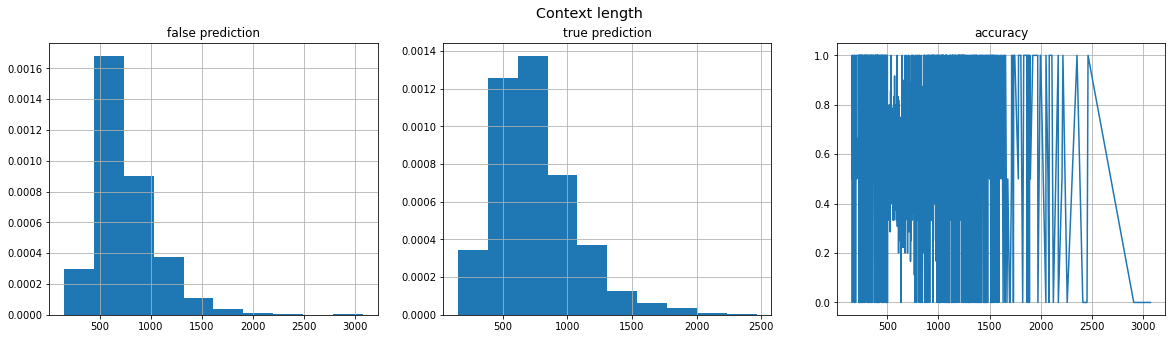

In [597]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes[0].hist(data_df[data_df.is_true == False].context_len, density = True)
axes[1].hist(data_df[data_df.is_true].context_len, density = True)
axes[2].plot(acc_context_df.x, acc_context_df.y)
# fig.tight_layout()
[ax.grid() for ax in axes]
axes[0].set_title('false prediction')
axes[1].set_title('true prediction')
axes[2].set_title('accuracy')
fig.suptitle("Context length", fontsize="x-large")
plt.show()

In [581]:
# data_df[data_df.is_true].context_len.value_counts()

**Answer length performance**

In [582]:
acc_answer_df = pd.DataFrame()
target = data_df[data_df.is_true].answer_len.value_counts()
for x,y in data_df.answer_len.value_counts().sort_index().iteritems():
    # print(x,y)
    if (x in target):
        y_true = target.loc[x]
    else:
        y_true = 0
    df_ = pd.DataFrame([[x, y_true / y]], columns=list('xy'))
    acc_answer_df = acc_answer_df.append(df_, ignore_index=True)

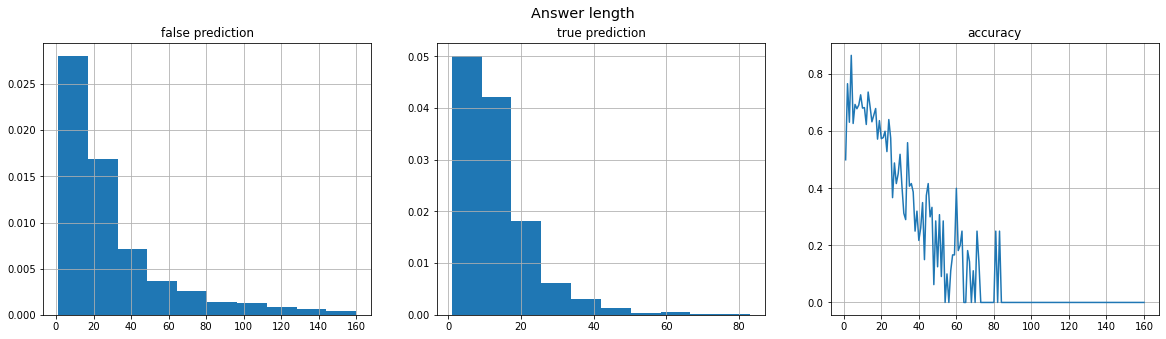

In [583]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes[0].hist(data_df[~data_df.is_true].answer_len, density = True)
axes[1].hist(data_df[data_df.is_true].answer_len, density = True)
axes[2].plot(acc_answer_df.x, acc_answer_df.y)
# fig.tight_layout()
[ax.grid() for ax in axes]
axes[0].set_title('false prediction')
axes[1].set_title('true prediction')
axes[2].set_title('accuracy')
fig.suptitle("Answer length", fontsize="x-large")
plt.show()

BONUS: Can you think of other axes that would be interesting to use to evaluate your model?

**Answer:** It seems like the longer the answer the worse the prediction accuracy. <br>
Other interesting axes for evaluating the model can be: 
1. question length 
2. type of question - quantative / qualitative (i.e. numerical data vs categorical)

### [Advanced] Fine-tune a Model
Here, you will fine-tune a base model to the Squad dataset, and evaluate its performance. 

Note that since the model is large, running this exercise might cost dozens of dollars. You’re very encouraged to use your AWS credits for that. We also recommend to work on the code on a cheap CPU-based machine, make sure that it runs properly, and then move to more expensive instances with GPUs for actual runs.

What metric do you find suited? Why?


In [584]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [587]:
tokenized_squad = datasets.map(preprocess_function, batched=True, remove_columns=datasets["train"].column_names)

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [591]:
tokenized_squad, datasets

(DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
         num_rows: 87599
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
         num_rows: 10570
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['id', 'title', 'context', 'question', 'answers'],
         num_rows: 87599
     })
     validation: Dataset({
         features: ['id', 'title', 'context', 'question', 'answers'],
         num_rows: 10570
     })
 }))

In [592]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [595]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=distilbert_squad_model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [596]:
# trainer.train()

***** Running training *****
  Num examples = 87599
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16425


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 18874368 bytes.

Train the model to fine-tune on the dataset. 

Make sure you use ClearML to report your results in real-time.

Write below your train and validation loss. You can compare your results to those of others from the class using ClearML.

## ClearML Integration
You can join the ClearML slack channel at  https://join.slack.com/t/clearml/shared_invite/zt-c0t13pty-aVUZZW1TSSSg2vyIGVPBhg to ask questions and see real life examples and questions of industry users.

### Parameters & Configurations
Keep your parameters/configs in a single dict within your code. For example 

`config={"param":"data", ...}`

This way you can easily connect into clearml using

`Task.connect(config)`

The documentation is here:
https://clear.ml/docs/latest/docs/references/sdk/task#connect_configuration


### Comparisons
Once you gathered some data, you can select multiple experiments and compare them, as detailed here: https://clear.ml/docs/latest/docs/webapp/webapp_exp_comparing/

### Additional Videos
We also recommend you review these videos to learn industry best practices:
- Day in the life of a data scientist - This video will cover nearly everything your might need to use clearml - https://www.youtube.com/watch?v=quSGXvuK1IM
- Detection in video on raspberry pi – a real world example of what can be done with ML (an example of a nice portfolio project) -  https://www.youtube.com/watch?v=ZiOr9EdYEeE


## Recommended Resources
For an open discussion on Question Answering related topics, you are very encouraged to watch this workshop: https://www.youtube.com/watch?v=Ihgk8kGLpIE

This screencast uses T5 on a different Q&A dataset: https://www.youtube.com/watch?v=_l2wJb3QPdk



That's it - good luck!